# StyleCLIP+: LLM-Powered Text Prompt Refinement (Preliminary Version)
Fall 2023 CS470 Introduction to Artificial Intelligence Project 2 (Implementation), Team 3  
Myeongseok Kwon<sup>1</sup>, Junhak Ha<sup>2</sup>, Dongwan Hong<sup>3</sup>, Kyeongmin Lee<sup>4</sup>, Bryan Nathanael Wijaya<sup>5*</sup>  
<small><sup>1</sup>20170042, <sup>2</sup>20190683, <sup>3</sup>20190696, <sup>4</sup>20200429, <sup>5</sup>20200735, <sup>*</sup>Team Leader</small>

**Remarks:** The LLM-powered text prompt refinement is now already implemented in integration with the vanilla StyleCLIP. This Google Colab notebook only serves as a preliminary version for easy experimentation.

## General setup and argument settings

In [ ]:
#@title General development environment setup
import time, os
import torch
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

if not os.path.exists('./StyleCLIP'):
    !git clone https://github.com/bramyeon/StyleCLIP.git
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from tqdm import tqdm

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 899, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 899 (delta 169), reused 188 (delta 131), pack-reused 618
Receiving objects: 100% (899/899), 200.06 MiB | 27.37 MiB/s, done.
Resolving deltas: 100% (314/314), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bbd480c7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bbd480c7
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=a732edd7785aec6fe5be7f196cb018ece2fd192538a31f3f17b333fa1685b777
  Stored in directory: /tmp/pip-ephem-wheel-cache-okhl1r84/wheels/da/2b/4c/d6691fa9597aac8bb85d2a

In [ ]:
#@title Setting up input image, text prompt, and the StyleGAN model

#@markdown Specify the `text_prompt` you want to use to manipulate the image.
text_prompt = "a bald eagle" #@param {type:"string"}
#@markdown Choose your pretrained StyleGAN `model`. They are enlisted as (StyleGAN architecture, training dataset, application domain, model checkpoint name).
model = "StyleGAN2, FFHQ, human face, stylegan2-ffhq-config-f.pt" #@param ['StyleGAN2, FFHQ, human face, stylegan2-ffhq-config-f.pt','StyleGAN2, FFHQ, human face, stylegan2-ffhq-config-f.pkl','StyleGAN2, LSUN Car, car, stylegan2-car-config-f.pkl','StyleGAN2, LSUN Church, church building, stylegan2-church-config-f.pkl','StyleGAN2-ada, AFQH Dog, dog, afhqdog.pkl','StyleGAN2-ada, AFQH Cat, cat, afhqcat.pkl','StyleGAN2-ada, AFQH Wild, wild animals, afhqwild.pkl','StyleGAN3, WikiArt, artistic painting, wikiart-1024-stylegan3-t-17.2Mimg.pkl','StyleGAN3, LHQ, landscapes, lhq-256-stylegan3-t-25Mimg.pkl']
architecture, dataset, description, ckpt = model.split(', ')
#@markdown Choose the StyleCLIP `method` to use.
method = "Latent Optimization" #@param ['Latent Optimization', 'Latent Mapper', 'Global Directions']
#@markdown Do you want to `use_llm` to refine your text prompt?
use_llm = True #@param {type:"boolean"}


## (Optional) Refining text prompt with LLM

In [ ]:
#@title Downloading Llama 2 Chat model checkpoint with 7B parameters (skip if already exists)
if use_llm and not os.path.exists('./llama-2-7b-chat.ggmlv3.q4_1.bin'):
    !wget https://huggingface.co/TheBloke/Llama-2-7B-Chat-GGML/resolve/main/llama-2-7b-chat.ggmlv3.q4_1.bin

--2023-11-16 14:11:02--  https://huggingface.co/TheBloke/Llama-2-7B-Chat-GGML/resolve/main/llama-2-7b-chat.ggmlv3.q4_1.bin
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.90, 3.163.189.74, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/30/e3/30e3aca7233f7337633262ff6d59dd98559ecd8982e7419b39752c8d0daae1ca/b379a454d32593089f663914c5a4687d95fd37e3bcddf826f9fb107598a8ff50?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27llama-2-7b-chat.ggmlv3.q4_1.bin%3B+filename%3D%22llama-2-7b-chat.ggmlv3.q4_1.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1700403062&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMDQwMzA2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8zMC9lMy8zMGUzYWNhNzIzM2Y3MzM3NjMzMjYyZmY2ZDU5ZGQ5ODU1OWVjZDg5ODJlNzQxOWIzOTc1MmM4Z

In [ ]:
#@title Installing LangChain and Llama.cpp with `pip` (if not yet installed)
if use_llm:
    !pip install langchain llama-cpp-python==0.1.78

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.1.78-cp310-cp310-linux_x86_64.whl size=296587 sha256=4b2565516412339db42fa8ce6df14f6a20e28690bffeeda66a8124010fbee73d
  Stored in directory: /root/.cache/pip/wheels/61/f9/20/9ca660a9d3f2a47e44217059409478865948b5c8a1cba70030
Successfully built llama-cpp-python


In [ ]:
#@title Setting up and initializing Llama 2
if use_llm:
    #@markdown Specify the path to your model checkpoint in `model_path`.<br>If you downloaded Llama in this notebook, use the default path: `./llama-2-7b-chat.ggmlv3.q4_1.bin`
    model_path = "./llama-2-7b-chat.ggmlv3.q4_1.bin" #@param {type:"string"}

    from langchain.llms import LlamaCpp
    #from langchain.chains import LLMChain
    #from langchain.callbacks.manager import CallbackManager
    #from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

    # Callbacks support token-wise streaming
    #callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

    start = time.time()
    llm = LlamaCpp(
        model_path=model_path,
        temperature=0.75,
        max_tokens=2000,
        top_p=1#,
        #callback_manager=callback_manager,
        #verbose=True,  # Verbose is required to pass to the callback manager
    )
    print(f"Initialization took {time.time()-start} seconds.")

Initialization took 19.313682317733765 seconds.


AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | VSX = 0 | 


In [ ]:
#@title Refining text prompt with Llama 2
if use_llm:
    prompt = f"""
    Context: Modify the text in the following (text, class) tuple to be a relevant description relevant to the class. State your final answer only, without explanation.
    Examples:
        (a happy sky, face) => a happy girl
        (a sad face, face) => a sad face
        (a colorful boy, face) => a cheerful boy
    Question: ({text_prompt}, {description}) =>
    """
    print(f"Prompt to LLM: {prompt}")
    start = time.time()
    text_prompt = llm(prompt).split(':')[-1].strip()
    print(f"Refinement took {time.time()-start} seconds.")
    print(f"The refined text prompt is '{text_prompt}'.")

Prompt to LLM: 
    Context: Modify the text in the following (text, class) tuple to be a relevant description relevant to the class. State your final answer only, without explanation.
    Examples:
        (a happy sky, face) => a happy girl
        (a sad face, face) => a sad face
        (a colorful boy, face) => a cheerful boy
    Question: (a bald eagle, human face) =>
    


Llama.generate: prefix-match hit


Refinement took 5.261541128158569 seconds.
The refined text prompt is 'a wise old man'.


## Approach 1: Latent Optimization

In [ ]:
#@title Development environment setup for Latent Optimization (may take a few minutes)

if method == 'Latent Optimization':
    os.chdir(f'./StyleCLIP')

    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # downloads StyleGAN's weights and facial recognition network weights
    from StyleCLIP.utils import google_drive_paths
    ckpt_id = google_drive_paths[ckpt].split('=')[-1]
    ids = [ckpt_id, '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
    for file_id in ids:
        downloaded = drive.CreateFile({'id':file_id})
        downloaded.FetchMetadata(fetch_all=True)
        downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
#@title Setting up the arguments for Latent Optimization

if method == 'Latent Optimization':
    #@markdown Choose your `experiment_type`. You can `edit` a given image or `free_generation` synthetic images.
    experiment_type = 'edit' #@param ['edit', 'free_generation']
    #@markdown Decide your `latent_path` if any.
    latent_path = None #@param {type:"string"}
    #@markdown How many optimization steps do you want? The original work suggests a value between 200 to 300.
    optimization_steps = 40 #@param {type:"number"}
    #@markdown The loss function to minimize for Latent Optimization is given by $L_{\mathrm{Lat. Opt.}}= D_{\mathrm{CLIP}}(G(w),t)+\lambda_{\mathrm{L2}} ||w-w_s||_2+\lambda_{\mathrm{ID}}L_{\mathrm{ID}}(w)$. <br>Determine the $\lambda_{\mathrm{L2}}$ and $\lambda_{\mathrm{ID}}$ hyperparameter values in the loss function.
    l2_lambda = 0.008 #@param {type:"number"}
    id_lambda = 0.005 #@param {type:"number"}
    #@markdown Do you want to edit directly in the StyleGAN's `stylespace`?
    stylespace = False #@param {type:"boolean"}
    #@markdown Do you want to `create_video` of the manipulation process?
    create_video = False #@param {type:"boolean"}
    #@markdown Do you want to `use_seed` for torch? Set the torch manual `seed` if necessary.
    use_seed = True #@param {type:"boolean"}
    seed = 53 #@param {type: "number"}

    args = {
        "description": text_prompt,
        "ckpt": ckpt,
        "stylegan_size": 1024,
        "lr_rampup": 0.05,
        "lr": 0.1,
        "step": optimization_steps,
        "mode": experiment_type,
        "l2_lambda": l2_lambda,
        "id_lambda": id_lambda,
        "mse_lambda": 0,
        'work_in_stylespace': stylespace,
        "latent_path": latent_path,
        "truncation": 0.7,
        "save_intermediate_image_every": 1 if create_video else 20,
        "results_dir": "results",
        "ir_se50_weights": "model_ir_se50.pth"
    }

In [ ]:
#@title Manipulate image via Latent Optimization

if method == 'Latent Optimization':
    if use_seed:
        torch.manual_seed(seed)
    from StyleCLIP.optimization.run_optimization import main
    from argparse import Namespace
    result = main(Namespace(**args))

Loading ResNet ArcFace


loss: 0.7700;: 100%|██████████| 300/300 [01:53<00:00,  2.64it/s]


## Approach 2: Latent Mapper

<i>Development discontinued by TA feedback.</i>

## Approach 3: Global Direction

<i>Development discontinued by TA feedback.</i>

## Visualizing result

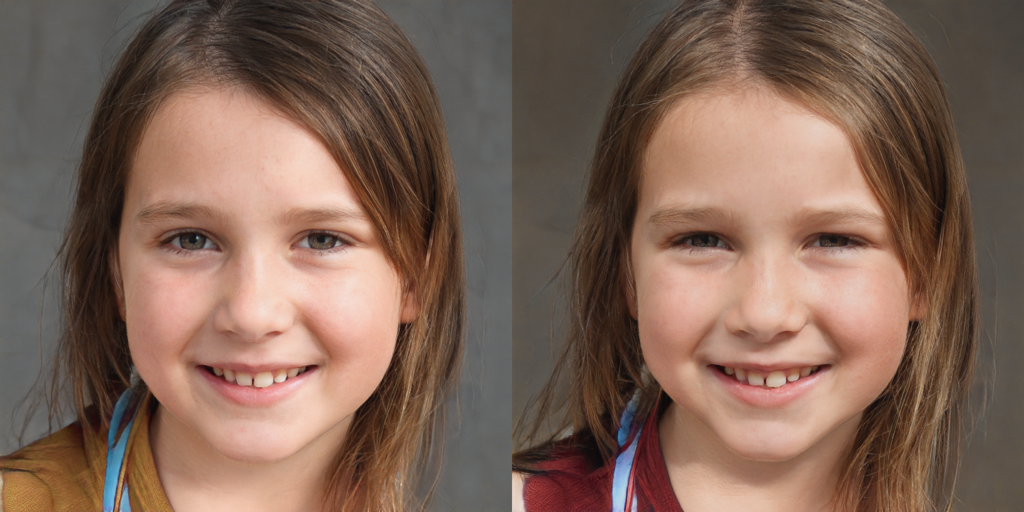

In [ ]:
#@title Visualize image manipulation result

result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, padding=0)) #range=(-1, 1)
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
#@title Create and download video of the manipulation process

!ffmpeg -r 15 -i results/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
from google.colab import files
files.download('out.mp4')

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## References
https://github.com/orpatashnik/StyleCLIP.git  
https://dev.to/eteimz/running-large-language-models-on-the-cpu-3a46  
https://python.langchain.com/docs/integrations/llms/llamacpp  